# PASO 1

In [2]:
# IMPORTACIÓN DE LIBRERÍAS
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# CARGA DE DATOS
data = fetch_california_housing(as_frame=True)
X = data.frame.drop(columns=['MedHouseVal']).values
y = data.frame['MedHouseVal'].values.reshape(-1, 1)
feature_names = data.feature_names

In [4]:
# TRAIN Y TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
# ESTANDARIZACIÓN
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# PASO 2

In [6]:
# AGREGACIÓN DE UNA COLUMNA
def add_intercept(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

X_train_b = add_intercept(X_train_s)
X_test_b = add_intercept(X_test_s)

In [7]:
# IMPLEMENTACIÓN MCO CERRADA
XtX = X_train_b.T @ X_train_b
XtX_inv = np.linalg.inv(XtX)
beta_hat = XtX_inv @ X_train_b.T @ y_train  # (p+1, 1)

intercept = beta_hat[0, 0]
coeffs = beta_hat[1:, 0]

print(f"Intercepto: {intercept:.4f}")
for name, c in zip(feature_names, coeffs):
    print(f"{name:>10s}: {c:.6f}")

Intercepto: 2.0719
    MedInc: 0.854383
  HouseAge: 0.122546
  AveRooms: -0.294410
 AveBedrms: 0.339259
Population: -0.002308
  AveOccup: -0.040829
  Latitude: -0.896929
 Longitude: -0.869842


# PASO 3

In [8]:
# PREDICCIONES
y_pred_ols = X_test_b @ beta_hat

# MÉTRICAS
mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)
print(f"MSE (OLS): {mse_ols:.4f}, R2: {r2_ols:.4f}")

MSE (OLS): 0.5559, R2: 0.5758


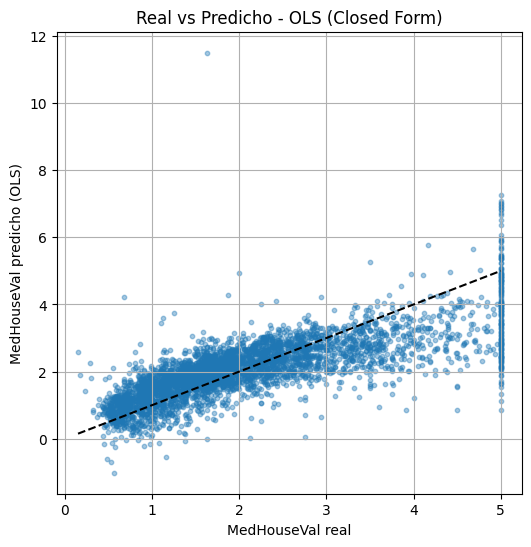

In [9]:
# GRÁFICO (REAL VS PREDICHO)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ols, alpha=0.4, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("MedHouseVal real")
plt.ylabel("MedHouseVal predicho (OLS)")
plt.title("Real vs Predicho - OLS (Closed Form)")
plt.grid()
plt.show()

# PASO 4

In [10]:
# DESCENSO DE GRADIENTE
def gradient_descent(X, y, lr=0.01, n_iter=2000, tol=1e-8):
    n_samples, n_features = X.shape
    beta = np.zeros((n_features, 1))
    cost_history = []
    
    for i in range(n_iter):
        y_pred = X @ beta
        error = y_pred - y
        gradient = (2/n_samples) * (X.T @ error)
        beta -= lr * gradient
        
        cost = (error**2).mean()
        cost_history.append(cost)
        
        # criterio de parada
        if i > 0 and abs(cost_history[-2] - cost_history[-1]) < tol:
            break
            
    return beta, cost_history

In [11]:
# PRUEBAS CON TASAS DE APRENDIZAJE
lrs = [0.01, 0.1]
gd_results = {}

for lr in lrs:
    beta_gd, costs = gradient_descent(X_train_b, y_train, lr=lr, n_iter=5000)
    gd_results[lr] = (beta_gd, costs)
    print(f"LR={lr}: costo final={costs[-1]:.6f}, iteraciones={len(costs)}")

LR=0.01: costo final=0.517938, iteraciones=4150
LR=0.1: costo final=0.517934, iteraciones=534


# PASO 5

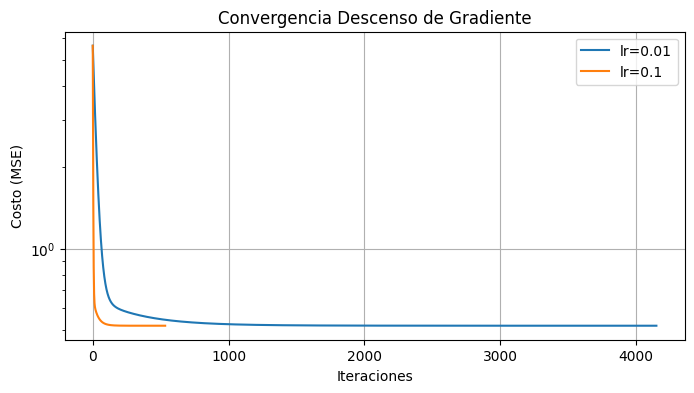

In [12]:
# GRÁFICO
plt.figure(figsize=(8,4))
for lr, (_, costs) in gd_results.items():
    plt.plot(costs, label=f"lr={lr}")
plt.yscale('log')
plt.xlabel("Iteraciones")
plt.ylabel("Costo (MSE)")
plt.title("Convergencia Descenso de Gradiente")
plt.legend()
plt.grid()
plt.show()

# PASO 6

In [13]:
for lr, (beta_gd, _) in gd_results.items():
    y_pred_gd = X_test_b @ beta_gd
    mse_gd = mean_squared_error(y_test, y_pred_gd)
    print(f"GD (lr={lr}) MSE: {mse_gd:.6f}")

print(f"OLS (cerrado) MSE: {mse_ols:.6f}")

GD (lr=0.01) MSE: 0.556100
GD (lr=0.1) MSE: 0.555971
OLS (cerrado) MSE: 0.555892
